# Classification using Optical Flow

We use optical flow to create velocity based feature vectors and classify between videos of 2 classes: with electric field and without electric field

In [1]:
import numpy as np

## File Upload

We read the tiff image files from the corresponding folders for videos including both with electric field and without electric field

In [2]:
import numpy as np 
from skimage import io
import os
import glob
img_dir = "flat cell videos/electric field/train" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
flat_EFtrain = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    flat_EFtrain.append(img)
    
img_dir = "flat cell videos/electric field/test" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
flat_EFtest = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    flat_EFtest.append(img)
    
img_dir = "ridged cell videos/electricfield/train" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
ridged_EFtrain = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    ridged_EFtrain.append(img)
    
img_dir = "ridged cell videos/electricfield/test" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
ridged_EFtest = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    ridged_EFtest.append(img)
    
img_dir = "flat cell videos/nofield" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
flat_nofield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    flat_nofield.append(img)
    
img_dir = "ridged cell videos/nofield" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*tif')
files = glob.glob(data_path)
ridged_nofield = []
for f1 in files:
    img = io.imread(f1)
    img = np.moveaxis(img,0,-1)
    ridged_nofield.append(img)

In [3]:
EF = flat_EFtrain + flat_EFtest + ridged_EFtrain + ridged_EFtest
NF = flat_nofield + ridged_nofield

# Optical flow calculation using feature tracking

Here we use OpenCV to perform optical flow calculation combined with feature tracker and create veclocity based feature vector for each video 

In [8]:
#*****run the code here******#
import numpy as np
import cv2 as cv
vel_EF = [] ##change NF and EF##


for im in EF: ##change NF and EF##
    im = np.moveaxis(im,(0,1,2),(1,2,0))
    vel = []
    im2 = []
    frame_num = 300

    j = 0

    while j < im.shape[0] - frame_num:
        im2.append(im[j:j+frame_num])
        j = j+frame_num
        
    if im.shape[0] >= frame_num:
        im2.append(im[-frame_num:])
        
    if len(im2) > 0:
        im2 = np.stack(im2,axis=0)
    else:
        im2 = np.reshape(im,(1,im.shape[0],512,512))
    
    for l in range(im2.shape[0]):
    # params for ShiTomasi corner detection
        feature_params = dict( maxCorners = 300, qualityLevel = 0.2, minDistance = 7, blockSize = 10 )
        # Parameters for lucas kanade optical flow
        lk_params = dict( winSize  = (30,30), maxLevel = 3, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
        # Create some random colors
        color = np.random.randint(0,255,(300,3))
        # Take first frame and find corners in it
        old_frame = cv.cvtColor(im2[l][0], cv.COLOR_GRAY2BGR)
        old_gray = im2[l][0]
        p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
        points_initial = p0.reshape(-1,2)

        list_images = []

        mask = np.zeros_like(old_frame)
        j = 1
        while j < im2[l].shape[0]:
            frame = cv.cvtColor(im2[l][j], cv.COLOR_GRAY2BGR)
            frame_gray = im2[l][j]
            # calculate optical flow
            p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
            # Select good points
            if p1 is not None:
                good_new = p1.reshape(-1,2)
                good_old = p0.reshape(-1,2)
            # draw the tracks
            for i,(new,old) in enumerate(zip(good_new, good_old)):
                a,b = new.ravel()
                c,d = old.ravel()
                mask = cv.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
                frame = cv.circle(frame,(int(a),int(b)),5,color[i].tolist(),-1)
            img = cv.add(frame,mask)
            list_images.append(img)
            k = cv.waitKey(30) & 0xff
            if k == 27:
                break
            # Now update the previous frame and previous points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1,1,2)
            j = j+1

        points_final = p0.reshape(-1,2)
        num_frames = j-1
        avg_vel = np.mean(points_final - points_initial, axis=0)/num_frames
        vel_norm = np.linalg.norm(avg_vel)
        vel.append(np.append(avg_vel, [vel_norm])) ##change NF and EF##
    vel = np.asarray(vel)
    vel_EF.append(vel)


In [9]:
len(vel_EF)

12

In [10]:
vel_NF = np.concatenate(vel_NF,axis=0)
vel_EF = np.concatenate(vel_EF,axis=0)

## Velocity magnitude

Here we present a histogram of the average velocity magnitude for each video

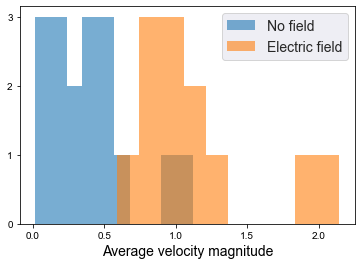

In [12]:
import matplotlib.pyplot as plt
import seaborn as sn

Features=['No field','Electric field']
plt.hist(vel_NF[:,2], alpha=0.6)
plt.hist(vel_EF[:,2], alpha=0.6)
sn.set(font_scale=2.0)
plt.legend(Features,loc=1, fontsize=14)
plt.xlabel('Average velocity magnitude',fontsize=14)
plt.show()

## Data splits and classification

We use scikit_learn's in-built train_test_split function to create random splits of the dataset into training and test set. We use SVM for classification and display the results using a confusion matrix.

In [13]:
X = np.concatenate((vel_NF, vel_EF),axis=0)
y = np.concatenate((np.zeros(vel_NF.shape[0]), np.ones(vel_EF.shape[0])), axis=0)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

In [15]:
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.svm import LinearSVC

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5]}               
clf = GridSearchCV(
    LinearSVC(class_weight=None, dual=True, max_iter=1000000000, penalty='l2'), param_grid
)
clf = clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 9.154s
Best estimator found by grid search:
LinearSVC(C=10, max_iter=1000000000)


In [16]:
from sklearn import svm, metrics
from sklearn.svm import LinearSVC

#classifier = LinearSVC(penalty='l1', dual=False, C=1.0, max_iter=10000)
classifier = LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000000000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

classifier.score(X_test,y_test)

Classification report for classifier LinearSVC(C=10, max_iter=1000000000):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10




1.0

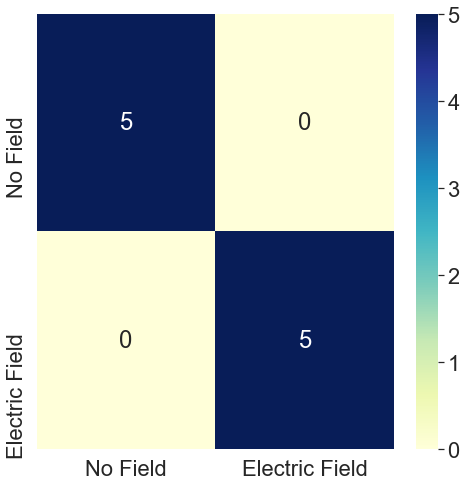

In [18]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

a = metrics.confusion_matrix(y_true=y_test, y_pred=predicted)
df_cm = pd.DataFrame(a, range(2), range(2))
plt.figure(figsize=(8,8))
df_cm = df_cm.rename(index={0: "No Field", 1: "Electric Field"}, columns={0: "No Field", 1: "Electric Field"})
sn.set(font_scale=2.0) # for label size
sn.heatmap(df_cm, cmap="YlGnBu", annot=True, fmt='.0f') # font size
plt.show()